In [17]:
# Imports and constants
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy.sql import text
from lib import Output, TaxiDBReader, runSql, GREEN, YELLOW, TABLES, tabulate, CHUNK_SIZE, TABLE_FORMAT, SEPARATOR, DR, getDF, COLUMNS, normalizedColumns, ALL_COLUMNS, TAXI_ZONES

from ts_toolbox import plot_rolling_mean_var, ACF_PACF_Plot

O = Output('output/ppt2_output.txt') 

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)


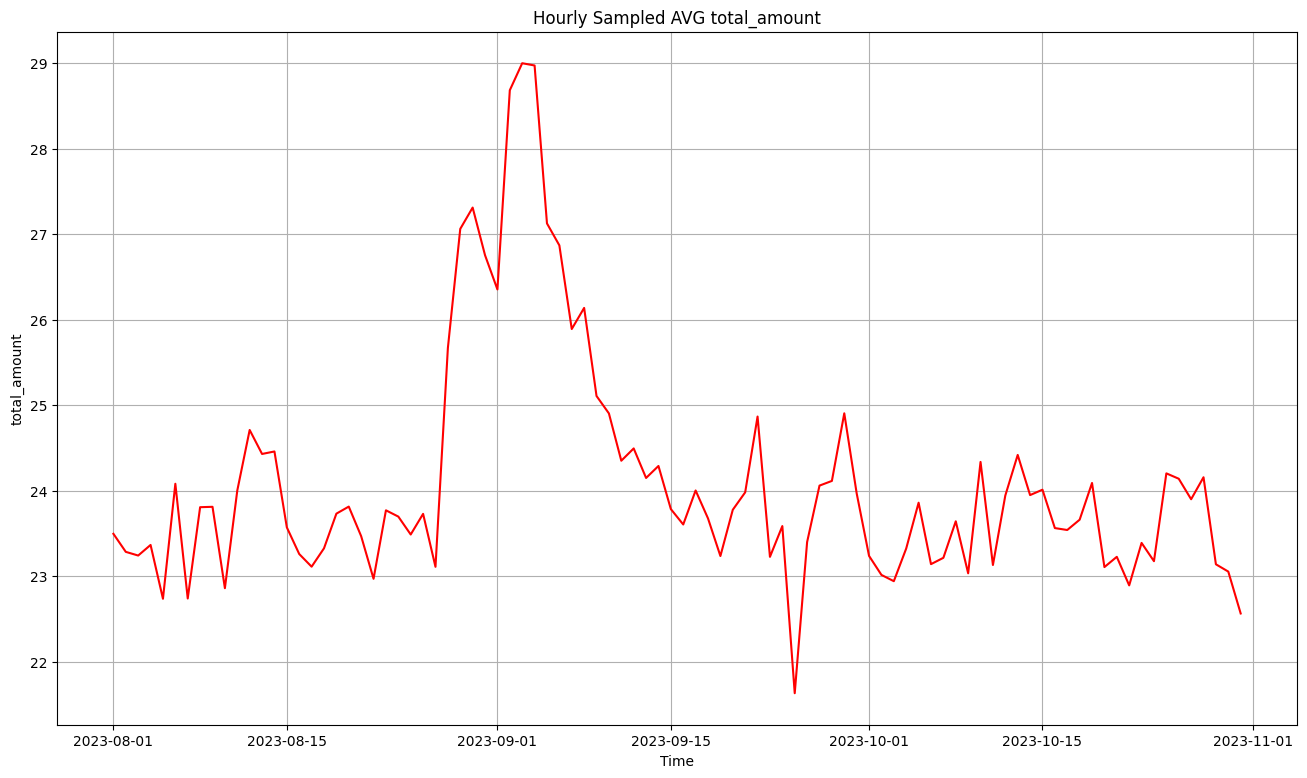

In [34]:
import matplotlib.dates as mdates

ctables = [
    (GREEN, 2023), # mar 3
    # (YELLOW, 2023) # oct 10
]

for t in ctables:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    O.out(f'table: {table_name}')
    uniq_table_name = DR.getTableName('uniq_')

    df = getDF(text(f'''
    WITH t AS (
        SELECT *, 
            (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
            CAST(strftime('%Y', pickup_datetime) as integer) as year
        FROM {uniq_table_name}
        WHERE year = {year}
    )
    SELECT (strftime('%Y-%m-%d', pickup_datetime)) as dt_hr, 
           AVG(f_total_amount) as total_amount, 
           AVG(f_fare_amount) as fare_amount, 
           AVG(f_trip_distance) as trip_distance,
           AVG(trip_duration) as trip_duration
    FROM t
    WHERE 
        CAST(strftime('%m', pickup_datetime) as integer)=8 OR
        CAST(strftime('%m', pickup_datetime) as integer)=9 OR
        CAST(strftime('%m', pickup_datetime) as integer)=10
    GROUP BY dt_hr
'''))

    df['dt_hr'] = pd.to_datetime(df['dt_hr'])
    # compare time distribution of variables like passengers, amount and distance of green taxi vs yellow taxi
    columns = [
        'total_amount',
    ]
    cmap = get_cmap(len(columns) + 1)
    for i, c in enumerate(columns):
        fig, ax = plt.subplots()
        fig.set_figwidth(16)
        fig.set_figheight(9)
        ax.plot(df['dt_hr'], df[c], color=cmap(i))
        # ax.xaxis.set_major_locator(mdates.DayLocator())
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

        plt.xlabel('Time')
        plt.ylabel(c)
        plt.grid(True)
        plt.title(f'Hourly Sampled AVG {c}')
        plt.show()

In [14]:
from sklearn.model_selection import train_test_split

DR.setTable(2023, GREEN)
utable = DR.getTableName('uniq_')
disptable  = DR.getTableName()

gdf = getDF(text(f'''
    WITH t AS (
        SELECT *, 
            (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
            CAST(strftime('%Y', pickup_datetime) as integer) as year
        FROM {utable}
        WHERE year = {2023}
    )
    SELECT (strftime('%Y-%m-%d %H', pickup_datetime)) as dt_hr, 
           AVG(f_total_amount) as total_amount, 
           AVG(f_fare_amount) as fare_amount, 
           AVG(f_trip_distance) as trip_distance,
           AVG(trip_duration) as trip_duration
    FROM t
    GROUP BY dt_hr
'''))

train_gdf, test_gdf = train_test_split(gdf, test_size=0.30)

print(f'train data shape: {train_gdf.shape}')
print(f'test data shape: {test_gdf.shape}')


train data shape: (6131, 5)
test data shape: (2628, 5)


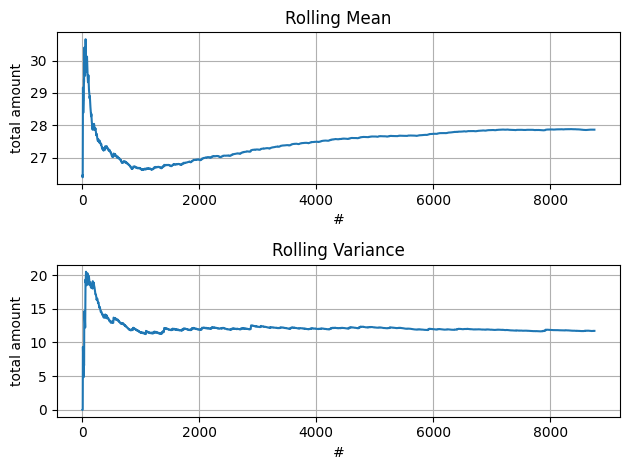

In [10]:
# rolling mean and variance
plot_rolling_mean_var(gdf['total_amount'], '#', 'total amount')

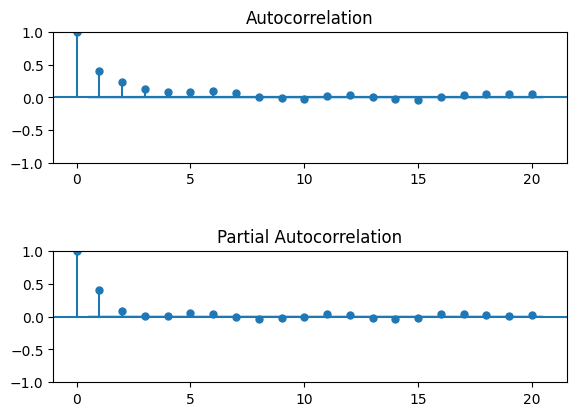

In [15]:
# acf and pacf plot
ACF_PACF_Plot(gdf['total_amount'], 20)

In [2]:
columns = ['trip_distance', 'fare_amount', 'mta_tax', 'total_amount', 'passenger_count']
prefix = 'f_'

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    O.out(f'table name: {table_name}')
    for c in columns:
        nc = prefix+c
        res = runSql(text(f'''
    SELECT COUNT(1) FROM {uniq_table_name} WHERE {nc}<>{c}
'''))
        O.out(f'Number of values updated using average method for {c}: {res.scalar()}')
    O.out(SEPARATOR)


In [4]:

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    O.out(f'table name: {table_name}')
    
    res = runSql(text(f'''
    SELECT COUNT(1) FROM {uniq_table_name}
'''))
    O.out(f'# of remaining rows after cleaning: {res.scalar()}')

O.out(SEPARATOR)


In [5]:
O.out(f'Total # of columns after cleaning: {len(ALL_COLUMNS)}')

In [ ]:
# Timeseries model application
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming df_daily['total_amount'] is your target series
# Split the data into train and test sets

year = 2023
DR.setTable(year, taxi_type)
table_name = DR.getTableName()
uniq_table_name = DR.getTableName('uniq_')
O.out(f'table: {table_name}')
sql = text(f'''
    WITH t AS (
        SELECT *, 
            (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration,
            CAST(strftime('%Y', pickup_datetime) as integer) as year
        FROM {uniq_table_name}
        WHERE f_trip_distance < 20 AND f_total_amount <= 100
            AND trip_duration > 0 AND trip_duration <= 7200
            AND year = {year}
    )
    SELECT (strftime('%Y-%m-%d %H', pickup_datetime)) as dt_hr, 
           AVG(f_total_amount) as total_amount, 
           AVG(f_fare_amount) as fare_amount, 
           AVG(f_trip_distance) as trip_distance,
           AVG(trip_duration) as trip_duration
    FROM t
    GROUP BY dt_hr
''')

df_daily = getDF(sql)

# train = df_daily['total_amount'][:'2023-06']
# test = df_daily['total_amount']['2023-07':]

# Fit an ARIMA model (start with default order, and tune it)
model = ARIMA(train, order=(p,d,q))  # You need to tune (p,d,q)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Plot the results
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Forecast')
plt.legend()
plt.show()
